In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import sys
import scipy.sparse as sp

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

sys.path.insert(1, '..')

from repsys.dataset import Dataset
from repsys.model import Model
from repsys.evaluators import ModelEvaluator
import repsys.dtypes as dtypes

In [2]:
s = pd.Series([3, 1, 2, 3, 4])

In [10]:
s.value_counts()[:2].index.tolist()

[3, 1]

In [64]:
df.set_index('id').index

Index(['3ffw2132', '41321weqw3'], dtype='object', name='id')

In [3]:
class MovieLens(Dataset):
    def name(self):
        return "movielens"

    def get_genres(self):
        return self.tags.get('genres')

    def item_cols(self):
        return {
            "movieId": dtypes.ItemID(),
            "title": dtypes.Title(),
            "genres": dtypes.Tag(sep="|"),
            "year": dtypes.Number(),
        }

    def interaction_cols(self):
        return {
            "movieId": dtypes.ItemID(),
            "userId": dtypes.UserID(),
            "rating": dtypes.Interaction(),
        }

    def load_items(self):
        df = pd.read_csv("./ml-sm/movies.csv")
        df["year"] = df["title"].str.extract("\((\d+)\)")
        df["year"] = df["year"].fillna(0)
        df["year"] = df["year"].astype(int)
        return df

    def load_interactions(self):
        return pd.read_csv("./ml-sm/ratings.csv")

In [11]:
dataset = MovieLens()
dataset.prepare()

In [12]:
dataset.items

,title,genres,year
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...
193579,Jon Stewart Has Left the Building (2015),[Documentary],2015
193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017


In [13]:
dataset.histograms.get('year')

(array([  11,    1,    0,    0, 8059]),
 array([   0. ,  403.6,  807.2, 1210.8, 1614.4, 2018. ]))

In [67]:
np.histogram(dataset.items['year'], range=(1900, 2020))

(array([   2,   10,   82,  208,  284,  416,  652, 1642, 2920, 1843]),
 array([1900., 1912., 1924., 1936., 1948., 1960., 1972., 1984., 1996.,
        2008., 2020.]))

In [88]:
dataset.items['year'].quantile(.1)

1966.0

In [89]:
dataset.items['year'].quantile(.9)

2013.0

<AxesSubplot:>

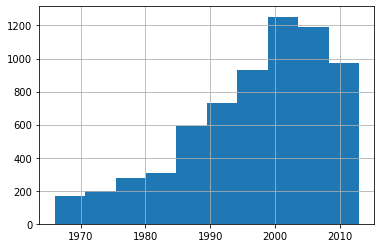

In [92]:
dataset.items['year'].hist(bins=10, range=(1966, 2013.0))

In [87]:
dataset.items['year'].median()

1999.0

In [37]:
class KNN(Model):
  def __init__(self, k=5):
    self.model = NearestNeighbors(n_neighbors=k, metric="cosine")

  def name(self):
    return "knn"

  def fit(self):
    self.model.fit(self.dataset.train_data)

  def predict(self, X, **kwargs):
    # the slowest phase of the prediction
    distances, indexes = self.model.kneighbors(X)

    n_distances = distances[:, 1:]
    n_indexes = indexes[:, 1:]

    n_distances = 1 - n_distances

    sums = n_distances.sum(axis=1)
    n_distances = n_distances / sums[:, np.newaxis]
        
    def f(dist, idx):
        A = self.dataset.train_data[idx]
        D = sp.diags(dist)
        return D.dot(A).sum(axis=0)
    
    vf = np.vectorize(f, signature='(n),(n)->(m)')

    pred = vf(n_distances, n_indexes)
        
    pred[(X > 0).toarray()] = 0

    return pred

In [38]:
model = KNN(k=20)
model.update_dataset(dataset)
model.fit()

In [39]:
X_pred = model.predict(dataset.vad_data_tr)

phase 1 done
phase 2 done


In [97]:
X_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.103728  , 0.21258559, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10169589, 0.2073023 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05775506, 0.48042479, 0.0515738 , ..., 0.        , 0.        ,
        0.        ]])